Disable warnings, set Matplotlib inline plotting and load Pandas package.

In [17]:
import warnings
warnings.filterwarnings('ignore')

#%matplotlib inline
import pandas as pd
#pd.options.display.mpl_style = 'default'    # mpl_style is deprecated

import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when

import seaborn as sns
import matplotlib.pyplot as plt

Load train dataset from HDFS and explore data. The dataset has the following fields. The Churn field is what we wants to predict.

In [18]:
#caminho = '../dataset/churn-bigml-80.csv'

caminho = os.getenv('TRAIN_DATA_PATH', '../dataset/churn-bigml-80.csv')

if not os.path.exists(caminho):
    raise FileNotFoundError(f"Arquivo não encontrado: {caminho}")

# Cria uma sessão do Spark
spark = SparkSession.builder \
    .appName("ChurnPrediction") \
    .getOrCreate()

# Agora use o spark.read (não precisa mais do sqlContext)
train_data = spark.read.load(
    caminho,
    format='csv',  # ou 'com.databricks.spark.csv' se estiver usando o pacote específico
    header='true',
    inferSchema='true'
)

train_data.cache()
train_data.printSchema()


root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



Explore the first five rows.

In [11]:
pd.DataFrame(train_data.take(5), columns=train_data.columns)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Show summary statistics of all fields.

In [12]:
train_data.describe().toPandas()

,summary,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,count,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666
1,mean,None,100.62040510127532,437.43885971492875,None,None,8.021755438859715,179.48162040510135,100.31020255063765,30.512404351087813,200.38615903976006,100.02363090772693,17.033072018004518,201.16894223555968,100.10615153788447,9.052689422355604,10.23702175543886,4.467366841710428,2.764489872468112,1.5626406601650413
2,stddev,None,39.56397365334985,42.521018019427174,None,None,13.61227701829193,54.21035022086982,19.988162186059512,9.215732907163497,50.95151511764598,20.16144511531889,4.330864176799864,50.780323368725206,19.418458551101697,2.2851195129157564,2.7883485770512566,2.4561949030129466,0.7528120531228477,1.3112357589949093
3,min,AK,1,408,No,No,0,0.0,0,0.0,0.0,0,0.0,43.7,33,1.97,0.0,0,0.0,0
4,max,WY,243,510,Yes,Yes,50,350.8,160,59.64,363.7,170,30.91,395.0,166,17.77,20.0,20,5.4,9


Tratamento de valores ausentes

In [13]:
print("\nVerificando e tratando valores ausentes...")


numerical_cols = [f.name for f in train_data.schema.fields if str(f.dataType) in ('DoubleType', 'IntegerType') and f.nullable]
categorical_cols = [f.name for f in train_data.schema.fields if str(f.dataType) == 'StringType' and f.nullable and f.name not in ['Phone']]

# Preencher NaNs em colunas numéricas com 0
print("Preenchendo NaNs em colunas numéricas com 0:")
for col_name in numerical_cols:
    train_data = train_data.fillna(0, subset=[col_name])

# Preencher NaNs em colunas categóricas com 'Unknown' ou valor padrão
print("Preenchendo NaNs em colunas categóricas com 'No' ou 'Unknown':")
for col_name in categorical_cols:
    # Para International plan e Voice mail plan, 'No' é um bom default se houver NaNs
    if col_name in ['International plan', 'Voice mail plan']:
        train_data = train_data.fillna('No', subset=[col_name])
    else:
        train_data = train_data.fillna('Unknown', subset=[col_name])


print("Valores ausentes tratados. Verificando novamente:")
train_data.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in train_data.columns]).show()
# --- FIM do Tratamento de NaNs ---


Verificando e tratando valores ausentes...
Preenchendo NaNs em colunas numéricas com 0:
Preenchendo NaNs em colunas categóricas com 'No' ou 'Unknown':
Valores ausentes tratados. Verificando novamente:
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+-----------

Count churn customers.

In [14]:
train_data.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
| true|  388|
|false| 2278|
+-----+-----+



Comparar número de cancelamentos (Churn) por tipo de plano

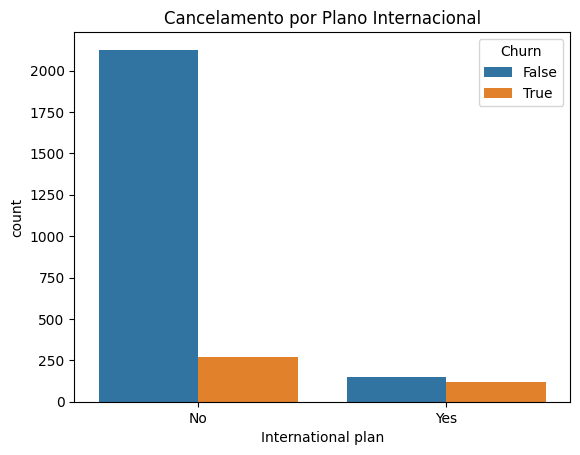

In [15]:

df = train_data.select('International plan', 'Churn').toPandas()
sns.countplot(data=df, x='International plan', hue='Churn')
plt.title('Cancelamento por Plano Internacional')
plt.show()

Salvar dataset limpo

In [16]:
output_path_parquet = '../dataset/churn-bigml-80_limpo'
train_data.write.mode('overwrite').parquet(output_path_parquet)


print(f"Dados limpos salvos em formato Parquet na pasta: {output_path_parquet}")

Dados limpos salvos em formato Parquet na pasta: ../dataset/churn-bigml-80_limpo
